In [1]:
get_ipython().run_cell_magic('capture', '', "%logstop\n%logstart -t -r -q ipython_command_log.py global\n\n#- IRONHACKS RESEARCH TRACKING CODE\n#----------------------------------\n\nimport os\nfrom datetime import datetime\nimport IPython.core.history as history\n\nha = history.HistoryAccessor()\nha_tail = ha.get_tail(1)\nha_cmd = next(ha_tail)\nsession_id = str(ha_cmd[0])\ncommand_id = str(ha_cmd[1])\ntimestamp = datetime.utcnow().isoformat()\nhistory_line = ','.join([session_id, command_id, timestamp]) + '\\n'\nlogfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')\nlogfile.write(history_line)\nlogfile.close()\n")

- LIBRARIES
------------------------------------------
DATA PROCESSING
import pandas, google-cloud-bigquery, chardet, click, cytoolz, dask, decorator, pyjson5, jsonschema, tables

STATISTICAL MODELING
import numpy, scipy, statsmodels, statistics, scikit-learn, patsy, simpy

DATA VISUALIZATION
import plotly, bokeh, seaborn, matplotlib, vincent

In [2]:
import csv
import pandas as pd
import numpy as np

In [3]:
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics

In [4]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt 

- PROJECT INFORMATION
------------------------------------------
These details for the Ironhack project are needed for the Query client

In [5]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

- DEFINE YOUR CLASSES AND FUNCTIONS 
----------------------------------

QUERY FUNCTION

In [6]:
def query_from_statement(query):
    query_job = bigquery_client.query(query)  # BIGQUERY 
    df = query_job.to_dataframe() # TURNING INTO PANDAS DF
    #display(df.tail(n=5))
    #print(df.shape)
    return df

In [7]:
u_claims_query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data`
Where week_number between 1 and 37
order by week_number
"""

In [8]:
unemployment_claims_data = query_from_statement(u_claims_query)

In [9]:
wage_query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.wage_data`
"""

In [10]:
unemployment_wage_data = query_from_statement(wage_query)

In [11]:
duplicated_rows = sum(unemployment_claims_data.duplicated()) # CHECKING FOR DUPLICATED ROWS
# THERE ARE 3079 DUPLICATED ROWS BETWEEN WEEKS 1 and 37
unemployment_claims_data = unemployment_claims_data.drop_duplicates()

In [12]:
duplicated_rows = sum(unemployment_wage_data.duplicated()) # CHECKING FOR DUPLICATED ROWS
# THERE ARE NO DUPLICATES

In [13]:
print(unemployment_claims_data.isna().sum())
print(unemployment_wage_data.isna().sum())

uu_id                         0
timeperiod                    0
week_number                   0
countyfips                    0
tract                         0
tract_name                    0
total_claims                  0
edu_8th_or_less            2532
edu_grades_9_11            9084
edu_hs_grad_equiv          8895
edu_post_hs               11305
edu_unknown                3922
top_category_employer1        0
top_category_employer2        0
top_category_employer3        0
gender_female             10800
gender_male               10703
gender_na                   784
race_amerindian            1275
race_asian                 1552
race_black                 8044
race_noanswer              5469
race_hawaiiannative         335
race_other                 7213
race_white                 8693
dtype: int64
uu_id           0
countyfips      0
tract           0
tract_name      0
average_wage    0
dtype: int64


In [14]:
unemployment_claims_data = unemployment_claims_data.fillna(0)
unemployment_wage_data = unemployment_wage_data.fillna(0)

In [15]:
data = unemployment_claims_data.join(unemployment_wage_data.set_index('uu_id'), on='uu_id',  rsuffix='_other') # JOINING 
data = data.drop(['countyfips_other', 'tract_other','tract_name_other'], axis=1) # REMOVING REPEATED COLUMNS IN BOTH TABLES

In [16]:
data = data.drop(['tract_name', 'top_category_employer1', 'top_category_employer2',
                  'top_category_employer3'], axis=1)
print(data.shape)
display(data.tail(n=5))

(13977, 22)


,uu_id,timeperiod,week_number,countyfips,tract,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,...,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage
16823,1ec881fbb0021331b2b29c95049284fb,20220910,37,18097,360201,30,0,0,20,0,...,20,0,0,0,25,0,0,0,0,10851.090909
16825,7f9c903be0e820137bd63ee9e9a97af8,20220910,37,18097,380403,14,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10175.769231
16827,447d5984bb8a8179bff002ccd1bba162,20220910,37,18081,610802,10,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13225.250000
16829,7dd5fff353cd08adc694aa74d7fa31af,20220910,37,18063,210202,13,0,0,0,0,...,0,0,0,0,0,0,0,0,13,10836.181818
16831,06c78e49b4daedfeb808c42e58fb25e4,20220910,37,18063,210603,11,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14976.000000


/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_15123/4266320550.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = data.corr().round(2)


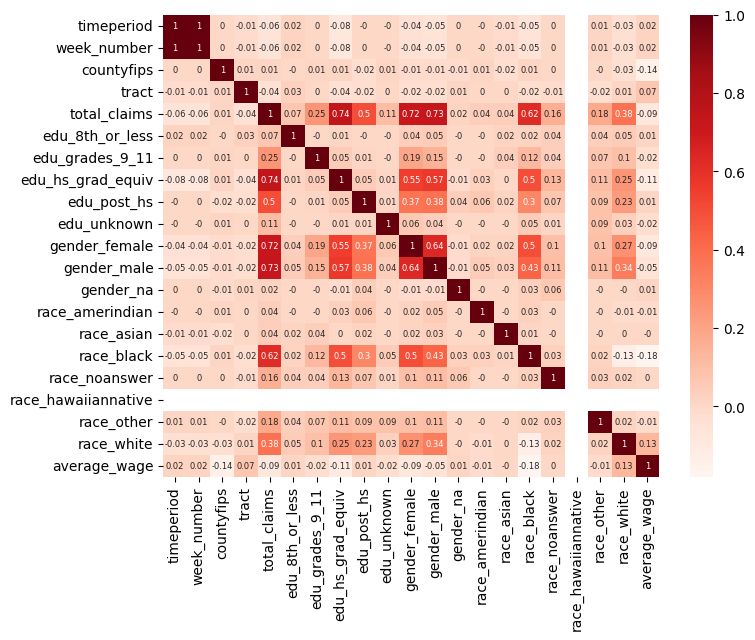

In [17]:
plt.figure(figsize=(8,6))
cor = data.corr().round(2)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, annot_kws={"size": 6})
plt.show()

In [18]:
data = data.drop(['uu_id','timeperiod'], axis=1)

In [19]:
y = np.array(data['total_claims'].values).reshape(-1,1)

In [20]:
data = data.drop(['total_claims'], axis=1)
X = data.values

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(f'Training Features Shape: {X_train.shape}')
print(f'Testing Features Shape: {X_test.shape}')
print(f'Training Labels Shape: {y_train.shape}')
print(f'Testing Labels Shape: {y_test.shape}')

Training Features Shape: (11181, 19)
Testing Features Shape: (2796, 19)
Training Labels Shape: (11181, 1)
Testing Labels Shape: (2796, 1)


In [22]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
print(regressor.intercept_)
print(regressor.coef_)

[-35.26931273]
[[-1.22283925e-03  2.69316416e-03 -4.69568365e-07  5.86020942e-01
   6.32881163e-01  5.10283623e-01  4.94158541e-01  6.68495665e-01
   1.61705948e-01  1.95442303e-01  2.23485955e-01 -4.57243957e-03
   3.18155841e-01  2.65015149e-01  3.23418086e-01 -1.33226763e-15
   3.74661880e-01  1.97184023e-01 -7.41196437e-06]]


In [23]:
y_pred = regressor.predict(X_test)

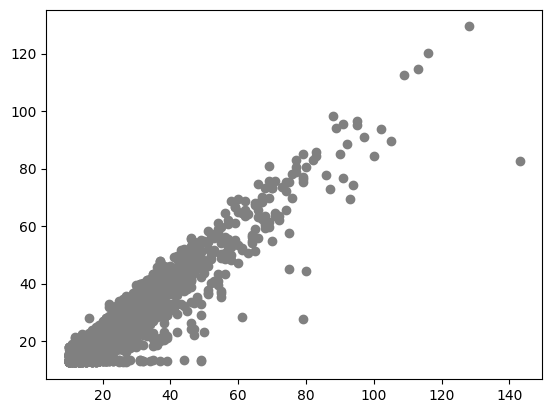

In [24]:
plt.scatter(y_test, y_pred,  color='gray')
plt.show()

In [25]:
metrics.mean_absolute_percentage_error(y_test, y_pred)

0.15931644849722298

In [26]:
prediction_query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.prediction_list`
"""

In [27]:
unemployment_prediction_data = query_from_statement(prediction_query)
print(unemployment_prediction_data.shape)
display(unemployment_prediction_data.head(n=5))

(525, 2)


,uu_id,week_number
0,5bf51fc2e162d6faf9e3cf79e4198378,44
1,420b44cc7e3f55d738df565421e59941,44
2,e39c66ecceec76ee8f9f811fa4a2d246,44
3,a90462cd11ae4e43144239bf7c4828a4,44
4,8b20a6749088c7ff1237983076ebfeaa,44


In [28]:
unemployclaims_supplemental_query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data`
Where week_number between 1 and 37
order by week_number
"""

In [29]:
unemployclaims_supplemental_data = query_from_statement(unemployclaims_supplemental_query)

In [30]:
# APPLYING ALL TRANSFORMATIONS TO THE LATEST WEEK ONLY DATAFRAME
unemployclaims_supplemental_data = unemployclaims_supplemental_data.drop_duplicates(subset=['uu_id'], keep='last')

In [31]:
unemployclaims_supplemental_data = unemployclaims_supplemental_data.join(unemployment_wage_data.set_index('uu_id'), on='uu_id',  rsuffix='_other') # JOINING
unemployclaims_supplemental_data = unemployclaims_supplemental_data.drop(['countyfips_other', 'tract_other','tract_name_other'], axis=1) # REMOVING REPEATED COLUMNS IN BOTH TABLES
unemployclaims_supplemental_data = unemployclaims_supplemental_data.drop(['tract_name', 'top_category_employer1', 'top_category_employer2', 'top_category_employer3'], axis=1)
unemployclaims_supplemental_data = unemployclaims_supplemental_data.drop(['timeperiod'], axis=1)
unemployclaims_supplemental_data = unemployclaims_supplemental_data.drop(['total_claims'], axis=1)

In [32]:
unemployclaims_supplemental_data = unemployclaims_supplemental_data.fillna(0)

In [33]:
print(unemployclaims_supplemental_data.shape)
display(unemployclaims_supplemental_data.head(n=5))

(525, 20)


,uu_id,week_number,countyfips,tract,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,edu_post_hs,edu_unknown,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white,average_wage
5793,420b44cc7e3f55d738df565421e59941,15,18043,70400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9019.666667
9226,aef08e5cd6bbf488ae574e9462f3e47b,25,18089,42704,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8861.000000
9576,38e264ca88c300dc19938de0abc88ec4,26,18019,50701,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19289.000000
9768,dfa86215568c869a2e94ce3e5fcf1661,27,18063,210900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5426.250000
9849,2ce8c1fbabbed69343d1af45e99c4839,27,18023,950200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,11884.333333


In [34]:
final_prediction_data = unemployment_prediction_data.join(unemployclaims_supplemental_data.set_index('uu_id'), on='uu_id',  rsuffix='_other') # JOINING
final_prediction_data = final_prediction_data.drop(['uu_id', 'week_number_other'], axis=1)
print(final_prediction_data.shape)

(525, 19)


In [35]:
future_regressor = LinearRegression()  
future_regressor.fit(X, y)
print(future_regressor.intercept_)
print(future_regressor.coef_)

[-41.39462189]
[[-5.12364419e-03  3.03800474e-03 -5.01349894e-07  5.95519055e-01
   6.36126746e-01  5.12920241e-01  4.99500873e-01  6.74193663e-01
   1.63003984e-01  1.95331329e-01  2.24198554e-01  3.62074727e-02
   5.04750001e-01  2.55214249e-01  3.38748011e-01  0.00000000e+00
   3.74923562e-01  1.92725327e-01 -9.44606555e-06]]


In [36]:
future = final_prediction_data.values
future_weeks_pred = future_regressor.predict(future)
print(future_weeks_pred.shape)

(525, 1)


In [37]:
unemployment_prediction_data['total_claims'] = future_weeks_pred.astype(int)
display(unemployment_prediction_data)

,uu_id,week_number,total_claims
0,5bf51fc2e162d6faf9e3cf79e4198378,44,12
1,420b44cc7e3f55d738df565421e59941,44,13
2,e39c66ecceec76ee8f9f811fa4a2d246,44,13
3,a90462cd11ae4e43144239bf7c4828a4,44,15
4,8b20a6749088c7ff1237983076ebfeaa,44,15
...,...,...,...
520,46c4f6c75e663b1ca82ea7994e6d83d3,44,35
521,1deebda501712e7595b531b8337bc31a,44,21
522,5a9758f65f001b6432ff31ff64a459d7,44,19
523,e8b3b95e93a6dc7dbb90f4e72e7ac065,44,18


In [38]:
unemployment_prediction_data.to_csv("submission_prediction_output.csv",index=False)